In [21]:
using Plots, LsqFit, TwoFAST, Dierckx, Printf, LaTeXStrings
using DelimitedFiles, SpecialFunctions

In [2]:
power_law(x, si, b, a) = a .+ b .* (x .^ si)

function power_law_b_a(xs, ys, si, p0; con = false)
     if con == true
          @assert length(p0) == 2 " b, a to be fitted, so length(p0) must be 2!"
          fit = curve_fit((x, p) -> power_law(x, si, p[1], p[2]), xs, ys, p0)
          return coef(fit)
     else
          @assert length(p0) == 1 " b to be fitted, so length(p0) must be 1!"
          fit = curve_fit((x, p) -> power_law(x, si, p[1], 0.0), xs, ys, p0)
          return vcat(coef(fit), 0.0)
     end
end;

In [3]:
function power_law_from_data(
     xs, ys,
     P0::Vector{Float64},
     fit_min::Number, fit_max::Number; con = false)

     @assert length(xs) == length(ys) "xs and ys must have same length"
     @assert length(P0) ∈ [2, 3] "length of P0 must be 2 or 3!"
     @assert min(xs...) <= fit_min "fit_min must be > min(xs...) !"
     @assert max(xs...) >= fit_max "fit_max must be < max(xs...) !"

     #p0 = abs(P0[1]) < 1.5 ? P0 : [ P0[1] - floor() , P0[2:end]...]
     p0 = P0

     mean_exp_xs = sum([log10(abs(x)) for x in xs[fit_min.<xs.<fit_max]]) / length(xs[fit_min.<xs.<fit_max])
     en_xs = 10.0^(-mean_exp_xs)
     new_xs = xs[fit_min.<xs.<fit_max] .* en_xs

     mean_exp_ys = sum([log10(abs(y)) for y in ys[fit_min.<xs.<fit_max]]) / length(ys[fit_min.<xs.<fit_max])
     en_ys = 10.0^(-mean_exp_ys)
     new_ys = ys[fit_min.<xs.<fit_max] .* en_ys

     mean_ys = sum(new_ys) / length(new_ys)
     @assert !all([isapprox(y / mean_ys, 1.0, rtol = 1e-6) for y in new_ys]) "DO NOT WORK!"
     #si = mean_spectral_index(xs, ys; N=N, con=con)

     if con == false
          @assert length(p0) == 2 " si,b to be fitted, so length(p0) must be 2!"
          vec = coef(curve_fit((x, p) -> power_law(x, p[1], p[2], 0.0),
               new_xs, new_ys, p0))
          si, b, a = vcat(vec, 0.0)
          return si, b * (en_xs^si) / en_ys, a / en_ys

     else
          @assert length(p0) == 3 " si,b,a to be fitted, so length(p0) must be 3!"

          try
               fit_1 = curve_fit((x, p) -> power_law(x, p[1], p[2], p[3]),
                    new_xs, new_ys, p0)
               vals_1 = coef(fit_1)
               stds_1 = stderror(fit_1)
               pers_1 = [s / v for (s, v) in zip(stds_1, vals_1)]

               si, b, a =
                    if all(x -> x < 0.05, pers_1)
                         vals_1
                    elseif pers_1[3] < 0.05
                         fit_2 = curve_fit((x, p) -> power_law(x, p[1], p[2], vals_1[3]),
                              new_xs, new_ys, p0)
                         vals_2 = coef(fit_2)
                         vcat(vals_2, vals_1[3])
                    else
                         fit_3 = curve_fit((x, p) -> power_law(x, p[1], p[2], 0.0),
                              new_xs, new_ys, p0)
                         vals_3 = coef(fit_3)
                         fit_4 = curve_fit((x, p) -> power_law(x, vals_3[1], vals_3[2], p[3]),
                              new_xs, new_ys, p0)
                         vals_4 = coef(fit_4)

                         vcat(vals_3, vals_4)
                    end

               return si, b * (en_xs^si) / en_ys, a / en_ys

          catch e
               fit_3 = curve_fit((x, p) -> power_law(x, p[1], p[2], 0.0),
                    new_xs, new_ys, [p0[1], p0[2]])
               si, b, a = vcat(coef(fit_3), 0.0)

               return si, b * (en_xs^si) / en_ys, a / en_ys
          end
     end
end;



function power_law_from_data(
        xs::Vector{Float64}, 
        ys::Vector{Float64}, 
        p0::Vector{Float64}; con = false)
     power_law_from_data(xs, ys, p0, xs[begin], xs[end]; con = con)
end;

In [4]:
si, b, a = -2.65, 1.54e3, 2.34563e-15
XS = 10 .^ range(4, 6, length=100)
YS = [a + b * x ^ (si)  for x in XS]
p0 = [-1.0, 1.0, 1.0]
c_si, c_b, c_a = power_law_from_data(XS, YS, p0; con = true)
calc_ys = [power_law(x, c_si, c_b, c_a) for x in XS]
c_si, c_b, c_a

(-2.6499999999999964, 1539.9999999999495, 2.3456299972577347e-15)

In [5]:
xs = XS
ys = YS
x1, x2 = xs[begin], xs[end]
mean_exp_xs = sum([log10(abs(x)) for x in xs[x1.<xs.<x2]]) / length(xs[x1.<xs.<x2])
en_xs = 10.0^(-mean_exp_xs)
new_xs = xs[x1.<xs.<x2] .* en_xs

mean_exp_ys = sum([log10(abs(y)) for y in ys[x1.<xs.<x2]]) / length(ys[x1.<xs.<x2])
en_ys = 10.0^(-mean_exp_ys)
new_ys = ys[x1.<xs.<x2] .* en_ys
ys

100-element Vector{Float64}:
 3.868305339087757e-8
 3.4196794383902e-8
 3.0230828356250145e-8
 2.6724814435067534e-8
 2.3625409768002156e-8
 2.0885457929195217e-8
 1.8463271449722345e-8
 1.6321997556420586e-8
 1.4429057469027441e-8
 1.2755650724720458e-8
 1.1276316988517128e-8
 9.968548682626014e-9
 8.812448541029353e-9
 ⋮
 7.546777600139873e-13
 6.674261936738752e-13
 5.90293610061058e-13
 5.221064622040623e-13
 4.618273050036336e-13
 4.0853901084570626e-13
 3.6143081580541915e-13
 3.1978598413981974e-13
 2.829709033885242e-13
 2.5042544416785295e-13
 2.2165443798590573e-13
 1.9622014341630197e-13

In [6]:
#plot(new_xs, new_ys)

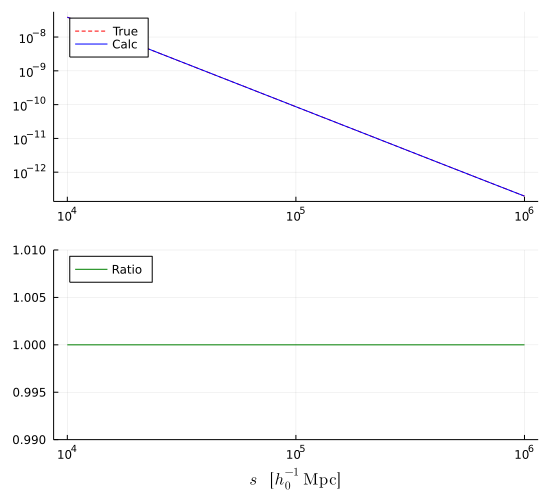

In [7]:
true_xs = XS
true_ys = YS
xs = XS
ys = calc_ys
spline = Spline1D(xs, ys)

S_VLIM = 1.0
S_VLIM_F = @sprintf("%.2f", S_VLIM)

p1 = plot(
    [true_xs[true_ys .> 0], xs[ys .> 0]], 
    [true_ys[true_ys .> 0], ys[ys .> 0]], 
    xaxis=:log, yaxis=:log, 
    lc=[:red :blue], 
    label=["True" "Calc"], ls=[:dash :solid], 
    legend=:topleft)
#vline!(p1, [S_VLIM], label="$S_VLIM_F Mpc/h_0", lc=:black, lw=0.5, ls=:dash)

p2 = plot(true_xs, spline.(true_xs) ./ true_ys, label="Ratio", lc=:green, 
    xaxis=:log,
    ylim=(0.99,1.01), legend=:topleft,
    xlabel=L"$s \quad [h_0^{-1}\,\mathrm{Mpc}]$")
#vline!(p2, [S_VLIM], label="$S_VLIM_F Mpc/h_0", lc=:black, lw=0.5, ls=:dash)

P = plot(p1, p2, size=(550, 500), layout= @layout [ x ; z ] )

In [8]:
function expand_left_log(xs, ys; 
        lim = 1e-8, fit_min = 0.05, fit_max = 0.5, 
        p0::Union{Vector{Float64}, Nothing} = nothing, 
        con::Bool = false)
    
    @assert fit_min < fit_max "fit_min must be < fit_max !"
    @assert lim < fit_min "lim must be < fit_min !"
    @assert min(xs...) <= fit_min "fit_min must be > min(xs...) !"
    @assert max(xs...) >= fit_max "fit_max must be < max(xs...) !"

     p_0 = isnothing(p0) ? (con==true ? [-1.0, 1.0, 0.0]  : [-1.0, 1.0]) : p0
     si, b, a = power_law_from_data(
          xs, ys, p_0, fit_min, fit_max; con = con)

     i = findfirst(x -> x > fit_min, xs) - 1
     f = xs[begin] / xs[begin+1]

     new_left_xs = unique(10 .^ range(log10(lim), log10(xs[i]), step = -log10(f)))
     new_left_ys = [power_law(x, si, b, a) for x in new_left_xs]

     return new_left_xs, new_left_ys
end;

function expand_right_log(xs, ys; 
        lim = 3e3, fit_min = 5.0, fit_max = 10.0, 
        p0::Union{Vector{Float64}, Nothing} = nothing, 
        con::Bool = false)
    
    @assert fit_min < fit_max "fit_min must be < fit_max !"
    @assert lim > fit_max "lim must be > fit_max !"
    @assert min(xs...) <= fit_min "fit_min must be > min(xs...) !"
    @assert max(xs...) >= fit_max "fit_max must be < max(xs...) !"

     p_0 = isnothing(p0) ? (con==true ? [-3.0, 1.0, 0.0]  : [-3.0, 1.0]) : p0
     si, b, a = power_law_from_data(
          xs, ys, p_0, fit_min, fit_max; con = con)

     i = findfirst(x -> x > fit_max, xs)
     f = xs[end] / xs[end-1]

     new_right_xs = unique(10 .^ range(log10(xs[i]), log10(lim), step = log10(f)))
     new_right_ys = [power_law(x, si, b, a) for x in new_right_xs]

     return new_right_xs, new_right_ys
end;

In [9]:
1.54e3 * 1e-6 ^ 2.64

2.2259772469487242e-13

In [10]:
si, b, a = -2.65, 1.54e3, 2.34563e-15
lim, fit_1, fit_2 = 1e2, 1e3, 1e4
XS = 10 .^ range(2, 4; length=100)
YS = [a + b * x ^ si for x in XS]
cutted_XS = XS[fit_1 .< XS .< fit_2]
cutted_YS = YS[fit_1 .< XS .< fit_2]
new_left_xs, new_left_ys = expand_left_log(XS, YS; 
    lim = lim, fit_min = fit_1, fit_max = fit_2, con=true);

In [11]:
for (x1,x2) in zip(new_left_xs, XS[XS .<= fit_1])
    println("$x1 \t $x2 \t $(x1-x2) \t $(x1/x2)")
end

100.0 	 100.0 	 0.0 	 1.0
104.76157527896652 	 104.76157527896652 	 0.0 	 1.0
109.74987654930568 	 109.74987654930557 	 1.1368683772161603e-13 	 1.000000000000001
114.97569953977369 	 114.97569953977356 	 1.2789769243681803e-13 	 1.000000000000001
120.45035402587835 	 120.45035402587824 	 1.1368683772161603e-13 	 1.0000000000000009
126.18568830660223 	 126.1856883066021 	 1.2789769243681803e-13 	 1.000000000000001
132.19411484660313 	 132.19411484660287 	 2.5579538487363607e-13 	 1.000000000000002
138.4886371393876 	 138.48863713938732 	 2.8421709430404007e-13 	 1.000000000000002
145.08287784959433 	 145.082877849594 	 3.126388037344441e-13 	 1.0000000000000022
151.99110829529377 	 151.99110829529332 	 4.547473508864641e-13 	 1.0000000000000029
159.22827933410971 	 159.22827933410923 	 4.831690603168681e-13 	 1.000000000000003
166.81005372000644 	 166.81005372000593 	 5.115907697472721e-13 	 1.000000000000003
174.752840000769 	 174.7528400007683 	 7.105427357601002e-13 	 1.000000000000

In [12]:
for (x1,x2) in zip(new_left_ys, YS[XS .<= fit_1])
    println("$x1 \t $x2 \t $(x1-x2) \t $(x1/x2)")
end

0.007718283397862354 	 0.007718283397862341 	 1.214306433183765e-17 	 1.0000000000000016
0.006823157044681527 	 0.006823157044681518 	 9.540979117872439e-18 	 1.0000000000000013
0.006031842788939488 	 0.006031842788939497 	 -8.673617379884035e-18 	 0.9999999999999986
0.0053323010436702786 	 0.005332301043670287 	 -8.673617379884035e-18 	 0.9999999999999983
0.004713888510566847 	 0.004713888510566851 	 -4.336808689942018e-18 	 0.9999999999999991
0.004167196245686742 	 0.004167196245686748 	 -5.204170427930421e-18 	 0.9999999999999988
0.0036839065054547985 	 0.003683906505454813 	 -1.431146867680866e-17 	 0.9999999999999961
0.003256666194921621 	 0.003256666194921634 	 -1.3010426069826053e-17 	 0.999999999999996
0.0028789749928346876 	 0.0028789749928347006 	 -1.3010426069826053e-17 	 0.9999999999999954
0.002545086451381634 	 0.002545086451381651 	 -1.691355389077387e-17 	 0.9999999999999933
0.00224992056587078 	 0.002249920565870795 	 -1.5178830414797062e-17 	 0.9999999999999932
0.00198

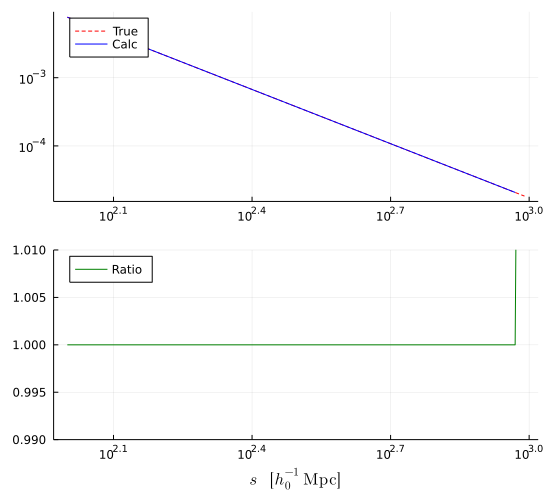

In [13]:
true_xs = XS[XS .< fit_1]
true_ys = YS[XS .< fit_1]
xs = new_left_xs
ys = new_left_ys
spline = Spline1D(xs, ys)

S_VLIM = 1.0
S_VLIM_F = @sprintf("%.2f", S_VLIM)

p1 = plot(
    [true_xs[true_ys .> 0], xs[ys .> 0]], 
    [true_ys[true_ys .> 0], ys[ys .> 0]], 
    xaxis=:log, yaxis=:log, 
    lc=[:red :blue], 
    label=["True" "Calc"], ls=[:dash :solid], 
    legend=:topleft)
#vline!(p1, [S_VLIM], label="$S_VLIM_F Mpc/h_0", lc=:black, lw=0.5, ls=:dash)

p2 = plot(true_xs, spline.(true_xs) ./ true_ys, label="Ratio", lc=:green, 
    xaxis=:log,
    ylim=(0.99,1.01), legend=:topleft,
    xlabel=L"$s \quad [h_0^{-1}\,\mathrm{Mpc}]$")
#vline!(p2, [S_VLIM], label="$S_VLIM_F Mpc/h_0", lc=:black, lw=0.5, ls=:dash)

P = plot(p1, p2, size=(550, 500), layout= @layout [ x ; z ] )

In [38]:
function func_I04_tilde(PK, s, kmin, kmax; kwargs...)
     res = quadgk(lq -> (sphericalbesselj(0, s * exp(lq)) - 1.0) * PK(exp(lq)) / (2.0 * π^2 * exp(lq)),
          log(kmin), log(kmax); kwargs...)[1]

     return res / (s^4)
end

function expanded_I04_tilde(PK, ss;
     kmin = 1e-6, kmax = 1e3, kwargs...)

     fit_1, fit_2 = 0.1, 1.0

     if all(ss .> fit_1)
          return [func_I04_tilde(PK, s, kmin, kmax; kwargs...) for s in ss]
     else
        ind = findfirst(x -> x>=fit_1, ss)
        cutted_ss = ss[ind-1:end]
          cutted_I04_tildes = [func_I04_tilde(PK, s, kmin, kmax; kwargs...) for s in cutted_ss]
          l_si, l_b, l_a = power_law_from_data(cutted_ss, cutted_I04_tildes,
               [-2.0, -1.0], fit_1, fit_2; con = false)
          #println("l_si, l_b, l_a = $l_si , $l_b , $l_a")
          left_I04_tildes = [power_law(s, l_si, l_b, l_a) for s in ss[ss.<=fit_1]]

        return vcat(left_I04_tildes, cutted_I04_tildes[2:end])
     end
end

expanded_I04_tilde (generic function with 1 method)

In [39]:
tab_I04_tildes = readdlm("../test/datatest/I04_tilde_extended_NO_CONST.txt", comments = true)
ss = convert(Vector{Float64}, tab_I04_tildes[:, 1])
I04_tildes = convert(Vector{Float64}, tab_I04_tildes[:, 2])

table_ips = readdlm("../test/datatest/file_pk.txt")
ks = convert(Vector{Float64}, table_ips[:, 1])
pks = convert(Vector{Float64}, table_ips[:, 2])
PK = Spline1D(ks, pks)
kmin, kmax = 1e-5, 1e3
calc_I04_tildes = expanded_I04_tilde(PK, ss; kmin = kmin, kmax = kmax);


In [40]:
true_xs = ss
true_ys = I04_tildes
xs = ss
ys = calc_I04_tildes
spline = Spline1D(xs, ys)

S_VLIM = 1.0
S_VLIM_F = @sprintf("%.2f", S_VLIM)

p1 = plot(
    [true_xs[true_ys .> 0], xs[ys .> 0]], 
    [true_ys[true_ys .> 0], ys[ys .> 0]], 
    xaxis=:log, yaxis=:log, 
    lc=[:red :blue], 
    label=["True" "Calc"], ls=[:dash :solid], 
    legend=:topleft)
#vline!(p1, [S_VLIM], label="$S_VLIM_F Mpc/h_0", lc=:black, lw=0.5, ls=:dash)

p2 = plot(true_xs, spline.(true_xs) ./ true_ys, label="Ratio", lc=:green, 
    xaxis=:log,
    ylim=(0.99,1.01), legend=:topleft,
    xlabel=L"$s \quad [h_0^{-1}\,\mathrm{Mpc}]$")
#vline!(p2, [S_VLIM], label="$S_VLIM_F Mpc/h_0", lc=:black, lw=0.5, ls=:dash)

P = plot(p1, p2, size=(550, 500), layout= @layout [ x ; z ] )

┌ Warning: No strict ticks found
└ @ PlotUtils /Users/matteofoglieni/.julia/packages/PlotUtils/xekml/src/ticks.jl:333
┌ Warning: No strict ticks found
└ @ PlotUtils /Users/matteofoglieni/.julia/packages/PlotUtils/xekml/src/ticks.jl:333
┌ Warning: No strict ticks found
└ @ PlotUtils /Users/matteofoglieni/.julia/packages/PlotUtils/xekml/src/ticks.jl:333
┌ Warning: No strict ticks found
└ @ PlotUtils /Users/matteofoglieni/.julia/packages/PlotUtils/xekml/src/ticks.jl:333
GKS: Possible loss of precision in routine SET_WINDOW
